Trevor Thomas

Anderson College of Business and Computing, Regis University

MSDS 682: Text Analytics

Dr. Nathan George


# Introduction

This assignment will focus on collecting an original data set from a social media website and performing a general analysis to uncover insights.  I chose to use Twitter because I want to analyze NFL-related tweets in real time as they are posted during Sunday's football games.  First, I will use the tweepy library to collect as many tweets containing either "NFL" or "football" as possible before the Twitter API's built-in limits stop me.  I will then clean the tweets and do basic exploratory data analysis by producing a word count, a wordcloud, a bigram count, and a bigram cloud to see the general NFL-related topics being discussed.  Then I will vectorize the tweets and do a basic cluster analysis to see how they naturally group together.  Finally, after splitting the data into training and test sets, I will use a Multinomial Naive Bayes classifier to see if the tweet text can be used to predict the source of the tweet (iPhone, Android, web, etc).  Each of these steps is detailed below with a discussion to follow.

# Import Libraries

The following libraries will be used to build this model.  Each is followed by a comment explaining its purpose.

In [4]:
import os  ## Used to import Twitter API keys from operating system
import tweepy  ## Used to collect tweets
from nltk.corpus import stopwords  ## List of stopwords for removal from data
from nltk.stem import *  ## Used for text cleaning
from nltk.probability import FreqDist  ## Used to produce word and bigram counts
from nltk.util import ngrams  ## Used to produce bigrams
from wordcloud import WordCloud  ## Used to produce word clouds
import re  ## Used to replace URL and username from tweets with sub() function
from sklearn.feature_extraction.text import TfidfVectorizer  ## Used to vectorize text data
from sklearn.cluster import KMeans  ## Used to perform cluster analysis
from sklearn.metrics import silhouette_score  ## Used in model evaluation
import numpy as np  ## Used to convert list to array
import pandas as pd  ## General use for data frame objects
import matplotlib.pyplot as plt  ## Used to visualize model evaluation
%matplotlib inline

# Initialize Global Variables

In [5]:
## Twitter API Keys
c_key = os.environ.get('TW_API_KEY')
c_sec = os.environ.get('TW_API_SECRET')
atk = os.environ.get('TW_ACCESS_TOKEN_KEY')
ats = os.environ.get('TW_ACCESS_TOKEN_SECRET')

auth = tweepy.OAuthHandler(c_key, c_sec)
auth.set_access_token(atk, ats)

api = tweepy.API(auth)

stop_words = stopwords.words('english')  ## Loading stopwords for removal
stop_words = set(stop_words + ['RT', 'rt', 'NFL', 'nfl', 'football', 'Football', 'app', 'yahoo', 'fox'])  ## Adding other common words for removal

# Collect Tweets and Tweet Sources in Lists

The following loop collects tweets 100 at a time (maximum allowable) and appends the text and the source data to separate lists.  Trial and error showed this loop would run 180 times before Twitter's API blocked it from continuing.  This was run several times throughout the day on Sunday, so the contents changed drastically based on which games were on.  The final collection was done between 5:00PM MST and 5:02PM MST, right as the afternoon games were wrapping up.

In [6]:
tweet_list = []
source_list = []
for i in range(180):
    if i%10 == 0:
        print(f"Loops: {i}")
    results = api.search(q='NFL' or 'football', count=100)
    for j in range(len(results)):
        tweet_list.append(results[j].text)
        source_list.append(results[j].source)

Loops: 0
Loops: 10
Loops: 20
Loops: 30
Loops: 40
Loops: 50
Loops: 60
Loops: 70
Loops: 80
Loops: 90
Loops: 100
Loops: 110
Loops: 120
Loops: 130
Loops: 140
Loops: 150
Loops: 160
Loops: 170


# Define Functions

Each function is described in the docstring.

In [7]:
def url_remover(data_frame):
    """
    Accepts a data frame, removes URLs and usernames from it, and returns the cleaned data frame.
    """
    temp_df = data_frame.apply(lambda x: re.sub('http://\S+', '', x))
    temp_df_02 = temp_df.apply(lambda x: re.sub('https://\S+', '', x))
    temp_df_03 = temp_df_02.apply(lambda x: re.sub('@\S+', ' ', x))
    return temp_df_03

def lower_alpha(samp_string):
    """
    Accept a string as an argument and return same string in lowercase with all non-alphabetical characters
    removed.
    """
    new_string = ""
    low_string = samp_string.lower()
    for char in low_string:
        if (96 < ord(char) < 123) or (ord(char) == 32):
            new_string += char
    return new_string

def no_stops(samp_string):
    """
    Accepts a string as an argument and returns a list containing to words from that string with the stopwords
    removed.
    """
    temp_list = samp_string.split()
    fin_list = []
    for word in temp_list:
        if word not in stop_words:
            fin_list.append(word)
    return fin_list

def lemmatizer(word_list):
    """
    Accepts a list of words as an argument and returns a list with the lemmatized version of each orignal
    word.
    """
    lemma_list = []
    lemmatizer = WordNetLemmatizer()
    for word in word_list:
        lemma_list.append(lemmatizer.lemmatize(word))
    return lemma_list

def stemmer(word_list):
    """
    Accepts a list of words as an argument and returns a list with the stemmed version of each original 
    word.
    """
    stem_list = []
    stemmer = SnowballStemmer("english")
    for word in word_list:
        stem_list.append(stemmer.stem(word))
    return stem_list

def string_cleaner(samp_string, lemma=True):
    """
    Accepts a string as an argument as well as a Boolean parameter "lemma".  Function passes string through
    preceding functions to clean text, returning the cleaned string.  If lemma is left as True, lemmatizer() 
    function is used.  If set to False, stemmer() function is used.
    """
    if lemma == True:
        word_list = lemmatizer(no_stops(lower_alpha(samp_string)))
    else:
        word_list = stemmer(no_stops(lower_alpha(samp_string)))
    output = " ".join(word_list)
    return output

# Clean Tweets

The following cell converts the tweets into a data frame so it can be passed to the URL_remover() function.  After being passed through URL_remover(), it is converted back to a list and passed through the string_cleaner() function to remove stopwords and format the text.  Finally, the tweet list and the source lists are stored in a dictionary and combined into the final data frame called tweet_df_02.

In [8]:
temp_df = pd.DataFrame(tweet_list)
no_url_tweet_list = list(url_remover(temp_df[0]))
clean_tweets = [string_cleaner(tweet) for tweet in no_url_tweet_list]

In [9]:
tweet_dict_02 = {'Tweets': clean_tweets, 'Source': source_list}
tweet_df_02 = pd.DataFrame(tweet_dict_02)

# Generate Wordcount and Wordcloud

The tweets are combined into one large string before being passed to FreqDist() and Wordcloud().generate() functions, which create word counts and wordclouds, respectively.

In [10]:
tweet_string = ""
for i in tweet_df_02['Tweets']:
    tweet_string += i + " "

In [11]:
wordcount = FreqDist(tweet_string.split())
wordcount.most_common(10)

[('game', 2944),
 ('season', 2415),
 ('first', 2242),
 ('contract', 2195),
 ('bengal', 2172),
 ('today', 2155),
 ('signed', 2025),
 ('retire', 2013),
 ('summer', 2013),
 ('cincinnati', 2013)]

(-0.5, 1199.5, 999.5, -0.5)

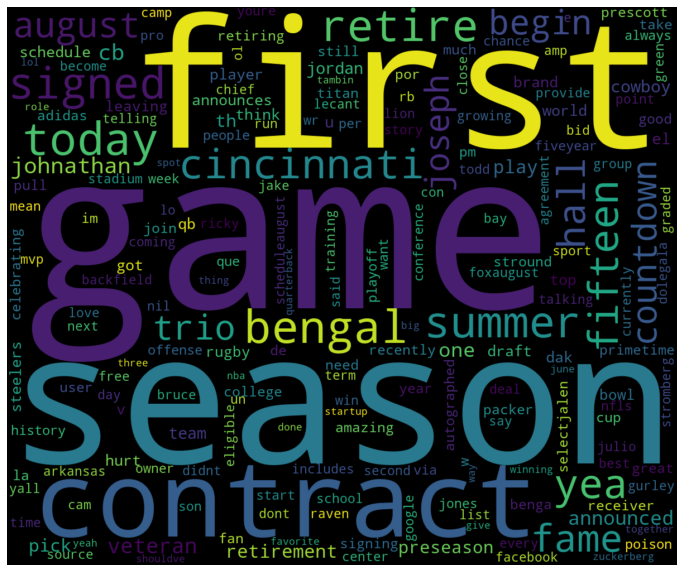

In [12]:
word_cloud = WordCloud(width=1200, height=1000, collocations = False).generate(tweet_string)
plt.figure(figsize=(12,12))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")

Both the word count and the wordcloud heavily reflect the time the tweets were collected, which was true regardless of the time of day this program was run.  With this final batch of tweets being collected right around the end of the afternoon games, most of the common words make sense for post-game analysis.  The words "receiver," "undrafted," "bronco", "rookie," etc most likely refer to the unusual game the Denver Broncos had, where they were forced to start an undrafted rookie wide receiver at quarterback due to their other quarterbacks being quarantined over COVID concerns.  This story dominated the news cycle for the day and was prevalent in the text analysis regardless of the time the tweets were collected, but it was especially pronounced at the end of that game.

## Wordcount and Wordcloud with Bigrams

I repeated the process from above using bigrams this time.

In [13]:
bigram_list = ngrams(tweet_string.split(), 2)
bigram_count = FreqDist(bigram_list)
bigram_count.most_common(10)

[(('today', 'retire'), 2013),
 (('retire', 'summer'), 2013),
 (('summer', 'signed'), 2013),
 (('signed', 'first'), 2013),
 (('first', 'contract'), 2013),
 (('contract', 'cincinnati'), 2013),
 (('cincinnati', 'bengal'), 2013),
 (('bengal', 'fifteen'), 2013),
 (('fifteen', 'yea'), 2013),
 (('hall', 'fame'), 1761)]

In [14]:
bigram_strings = ""
for i in range(len(list(bigram_count.values()))):
    wrd = list(bigram_count.keys())[i][0] + "_" + list(bigram_count.keys())[i][1]
    cnt = list(bigram_count.values())[i]
    gram_string = ((wrd + " ") * cnt)
    bigram_strings += gram_string

(-0.5, 1199.5, 999.5, -0.5)

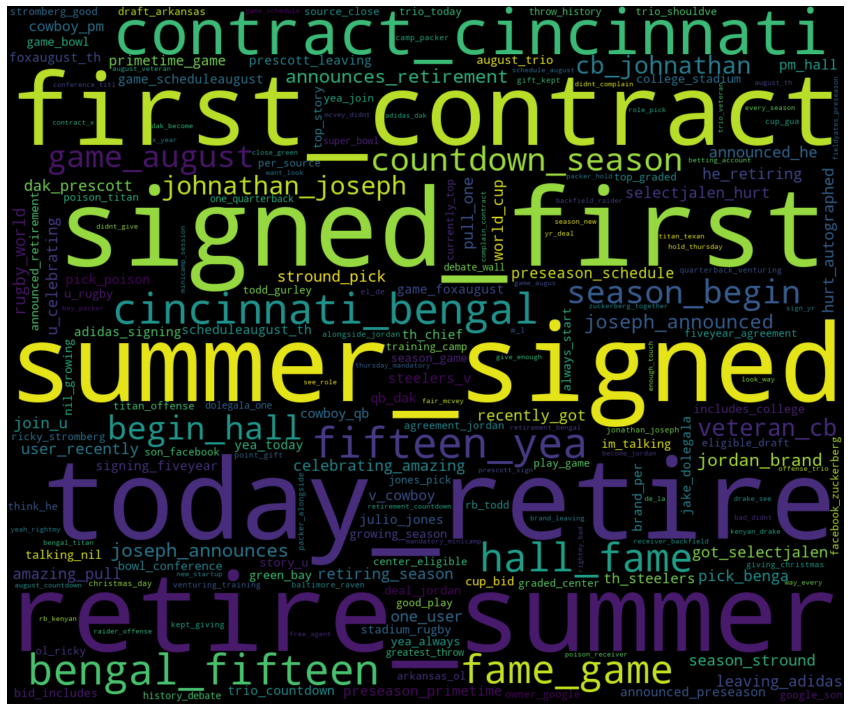

In [15]:
word_cloud = WordCloud(width=1200, height=1000, collocations = False).generate(bigram_strings)
plt.figure(figsize=(15,15))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")

The bigrams show Twitter conversation around the Broncos unusual game even more than the individual wordcloud.

# Cluster Analysis

I first vectorized the tweets using a TfIdf weighted document-term matrix.  I only counted terms that appeared at least twice to mitigate one-off internet slang terms and typos.

In [16]:
vectorizer = TfidfVectorizer(min_df=2)
nfl_vectors = vectorizer.fit_transform(clean_tweets)
nfl_vectors.shape

(18000, 825)

## Kmeans Optimization

I chose to use Kmeans to cluster the tweet vectors, so the following loop iterates through possible values of k and saves their within-cluster errors and silhouette scores to lists.  These lists will be used below to determine the optimal value of k.

In [17]:
wss = []
sil = []
for n in range(2, 20):
    print(n)
    model = KMeans(n_clusters=n, random_state=42, n_jobs=-1)
    model.fit(nfl_vectors)
    wss.append(-model.score(nfl_vectors))
    sil.append(silhouette_score(nfl_vectors, model.labels_, metric='euclidean'))

2


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


3


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


4


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


5


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


6


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


7


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


8


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


9


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


10


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


11


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


12


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


13


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


14


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


15


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


16


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


17


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


18


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


19


/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


### WSS Plot

The first graph below shows the within-cluster error on the vertical axis and the possible values of k on the horizontal axis.  While this graph cannot rigorously optimize k, it can give one an idea of where the best value might be through visual inspection.  The goal is to find the "elbow" in the graph, or the point of greatest inflection.

([<matplotlib.axis.XTick at 0x7f8616d6b040>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

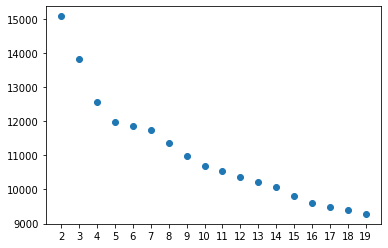

In [18]:
plt.scatter(range(2, 20), wss)
plt.xticks(range(2,20,1))

### Slope to left of point

This second graph plots the slope of the first graph to the left of each point.  By itself, it only indicates the rate of change from the previous value of k to the current value.  To find the point of greatest inflection, I need to identify the value of k with the greatest increase in slope from the left of the point to the right of the point, which is shown on the third graph further below.

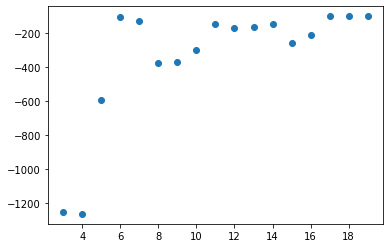

In [19]:
plt.scatter(range(3, 20), np.diff(wss))

### Slope change at each point

This clearly shows that k = 3 and k = 9 represent the biggest points of inflection.

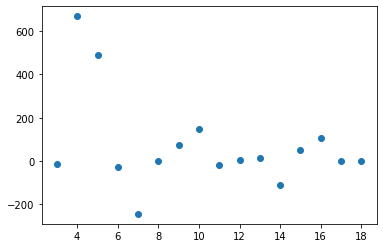

In [20]:
plt.scatter(range(3, 19), np.diff(np.diff(wss)))

### Silhouette scores

The silhouette scores charted below rise constantly as k increases, with a bend and leveling in the graph between k = 8 and k = 11.

0.4409473282800514 17


([<matplotlib.axis.XTick at 0x7f8616f2df70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

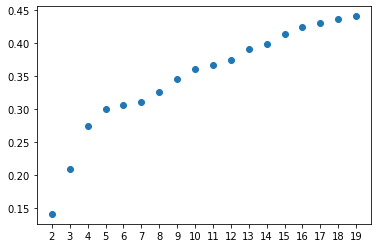

In [21]:
plt.scatter(range(2, 20), sil)
print(max(sil), sil.index(max(sil)))
plt.xticks(range(2,20,1))

## Kmeans Cluster with K = 9

Based on the visual analysis above, I chose to use k = 9 because it appeared as an optimum in both the elbow method and the silhouette method.  The output below provides the raw results with a detailed discussion and breakdown in the Results section at the end of this report.

In [22]:
nfl_clust_model_k9 = KMeans(n_clusters=9, random_state=42, n_jobs=-1)
nfl_clust_model_k9.fit(nfl_vectors)

/home/dpredbeard/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=9, n_jobs=-1, random_state=42)

### Word count for each cluster

In [23]:
cluster_k9_labels = nfl_clust_model_k9.predict(nfl_vectors)
obs_per_cluster_k9 = np.bincount(cluster_k9_labels)
wordcounts_k9 = []
for i in range(len(obs_per_cluster_k9)):
    cluster_tweets = np.array(clean_tweets)[cluster_k9_labels == i]
    wc = FreqDist(' '.join(cluster_tweets).split())
    wordcounts_k9.append(wc)
    print(wordcounts_k9[i])

<FreqDist with 726 samples and 69151 outcomes>
<FreqDist with 24 samples and 10440 outcomes>
<FreqDist with 7 samples and 9954 outcomes>
<FreqDist with 10 samples and 20130 outcomes>
<FreqDist with 2 samples and 1383 outcomes>
<FreqDist with 23 samples and 3064 outcomes>
<FreqDist with 100 samples and 13075 outcomes>
<FreqDist with 34 samples and 7869 outcomes>
<FreqDist with 12 samples and 4608 outcomes>


### 10 most common terms in each cluster

In [24]:
for i in range(len(wordcounts_k9)):
    print(f"Most common words in cluster {i}:\n",
        wordcounts_k9[i].most_common(10), "\n\n")

Most common words in cluster 0:
 [('game', 1419), ('th', 694), ('el', 619), ('team', 596), ('season', 591), ('player', 542), ('think', 537), ('v', 497), ('preseason', 439), ('pm', 409)] 


Most common words in cluster 1:
 [('joseph', 1188), ('johnathan', 1091), ('cb', 1072), ('veteran', 975), ('announced', 881), ('retirement', 786), ('announces', 573), ('he', 402), ('retiring', 402), ('season', 402)] 


Most common words in cluster 2:
 [('countdown', 1422), ('season', 1422), ('begin', 1422), ('hall', 1422), ('fame', 1422), ('game', 1422), ('august', 1422)] 


Most common words in cluster 3:
 [('today', 2013), ('retire', 2013), ('summer', 2013), ('signed', 2013), ('first', 2013), ('contract', 2013), ('cincinnati', 2013), ('bengal', 2013), ('fifteen', 2013), ('yea', 2013)] 


Most common words in cluster 4:
 [('trio', 1358), ('said', 25)] 


Most common words in cluster 5:
 [('pick', 294), ('poison', 294), ('offense', 294), ('titan', 266), ('julio', 262), ('jones', 262), ('rb', 108), ('k

# Naive Bayes

As indicated in the introduction, I wanted to see if the source of a tweet could be predicted based on the cleaned text inside the tweet.  I had to import a few additional libraries to complete this portion of the assignment.

In [25]:
from sklearn.naive_bayes import MultinomialNB ## Used to build Naive Bayes classifier
from sklearn.metrics import confusion_matrix ## Used in model evaluation
from sklearn.metrics import classification_report ## Used in model evaluation
from sklearn.model_selection import train_test_split  ## Used to split data

The following cell deletes the TfIdfVectorizer object used in the cluster analysis.  This step is not technically required, but I've found including it minimizes errors.  I always do it so I can guarantee that none of the test data is implicitly used to train the classifier, since the original vectorizer was built using the entire data set.

In [26]:
del vectorizer  ## Deleted old TfIdf object to ensure test data is not included in training

## Split and Vectorize Training and Test Data

In [27]:
tweet_train, tweet_test, source_train, source_test = train_test_split(tweet_df_02['Tweets'], tweet_df_02['Source'], test_size = .3, random_state=42)

In [28]:
vectorizer_02 = TfidfVectorizer(min_df=1)
train_vectors = vectorizer_02.fit_transform(tweet_train)
test_vectors = vectorizer_02.transform(tweet_test)

## Train Model, Make Predictions, and Evaluate Results

As with above, see the Results section for a detailed discussion.

In [29]:
mnb_nfl = MultinomialNB(alpha=.01)

mnb_mod = mnb_nfl.fit(train_vectors, source_train)

mnb_pred = mnb_mod.predict(test_vectors)

mnb_eval = classification_report(source_test, mnb_pred)

print(mnb_eval)

                         precision    recall  f1-score   support

                 Buffer       1.00      1.00      1.00        40
      Field Level Media       1.00      1.00      1.00        11
             SocialFlow       1.00      1.00      1.00        10
         SocialNewsDesk       1.00      1.00      1.00        29
      The Tweeted Times       1.00      1.00      1.00        53
TweetCaster for Android       0.06      1.00      0.11        28
              TweetDeck       0.65      1.00      0.79        91
        Twitter Web App       0.93      0.81      0.87      1031
    Twitter for Android       0.87      0.49      0.63       903
        Twitter for Mac       1.00      1.00      1.00        12
       Twitter for iPad       1.00      0.50      0.67        76
     Twitter for iPhone       0.86      0.87      0.87      2926
                dlvr.it       0.83      1.00      0.90       190

               accuracy                           0.80      5400
              macro avg

In [30]:
source_count = FreqDist(tweet_df_02['Source'])

In [31]:
source_count.most_common(10)

[('Twitter for iPhone', 9730),
 ('Twitter Web App', 3473),
 ('Twitter for Android', 2979),
 ('dlvr.it', 654),
 ('TweetDeck', 275),
 ('Twitter for iPad', 237),
 ('The Tweeted Times', 217),
 ('TweetCaster for Android', 106),
 ('SocialNewsDesk', 105),
 ('Buffer', 103)]

In [32]:
dominant_class_rate = source_count.most_common(1)[0][1] / len(tweet_df_02['Source'])
print(f"iPhone users represent {dominant_class_rate*100: .2f}% of Tweet sources")

iPhone users represent  54.06% of Tweet sources


# Results

A total of 18,000 tweets containing either "NFL" or "football" were collected during the NFL games on Sunday to perform a live analysis on NFL-related topics being discussed online.  After the data was collected, cleaned, and transformed, I performed both unsupervised clustering as well as supervised Naive Bayes Classification with interesting results in both cases.

## K Means Cluster Discussion

I chose to use k = 9 after a brief visual optimization, and the results were surprising.  First, I found that regardless of the value of k chosen, there was always one large "catch all" category of generic football tweets. In this case, Cluster 1 contains the majority of the data and is categorized by words like "game," "like," "play," "team," "call," etc.  After this generalized cluster, the remaining groups take one of two forms - they either identify a popular topic being discussed at the time the tweets were collected, or they represent a single tweet that was very popular and retweeted several times.  It is easy to distinguish between these groups, as the clusters representing a single popular tweet often do not even contain 10 words, and all the words appear nearly exactly as many times in the cluster.  An example of this can be seen in Cluster 5, which contains 9 words that each appear 169 times.  Cluster 6 is made up of 5 words that each appear 169 times, making me believe these were actually a single tweet that was incorrectly split.  Overall, this portion of the analysis showed that extremely recent NFL phenomena can be loosely understood by clustering tweets and that cluster analysis can be used to indirectly identify frequently retweeted tweets.

## Naive Bayes Classification Discussion

After deleting the old TfIdfVectorizer used for Kmeans, I built a new vectorizer by fitting it only to the training data.  I then transformed the test vectors to match the training vectors in length and passed both to the Naive Bayes algorithm in an attempt to predict the source of each tweet (iPhone, Android, web, etc).  I was shocked to find that the classifier performed well, even in the context of significant disparities in class size.  Unsurprisingly, iPhones were the most common source of tweets, representing about 62% of all data.  As is expected of dominant classes, the iPhone-sourced tweets had a higher recall than precision, but the gap was much smaller than anticipated.  With a recall of 94% and a precision of 85%, iPhone-sourced tweets were accurately predicted far more than the no information rate would suggest.  The model performed similarly well with Android tweets, and it was even able to achieve high precision and recall on some small classes with less than 10 samples.  Overall, the entire model achieved an f-score of 85%, so it appears there is a real difference in the way iPhone, Android, and other platforms engage with Twitter - or at least in the way they engage with football.

# Applications

It would be difficult to argue that this specific classifier has a direct application, as the tweet objects used to train the model are already tagged with the source (Android, iPhone, etc.).  However, it could be considered useful as part of a larger analysis.  As an example, say the NFL found, through hypothesis testing, that there was a measurable difference in how frequently Android and iPhone users engaged with their material, but no determination had been made about why this was the case.  This classifier could be used to show that those different user segments discuss the NFL using different vernacular, enough so that the model was able to predict the source of the each tweet with surprisingly high accuracy.  A justification could then be made to study the different modes of communication applied by Android and iPhone users, and therefore there would be reason to adjust the language used in the NFL's marketing toward each group, targetting Android and iPhone users with different tweets and advertisements.  It could even mean they would benefit from using different headlines on the same articles published to their Android and iPhone apps.  While there may never be a reason to create a data pipeline to use this predictor on tweets in real time, it could certainly provide insights for how the NFL and other football-focused media engage with their different user bases.